In [1]:
# This file is associated with the book
# "Machine Learning Refined", Cambridge University Press, 2016.
# by Jeremy Watt, Reza Borhani, and Aggelos Katsaggelos.

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import csv
from __future__ import division

A simple loading function.

In [2]:
# import training data 
def load_data(csvname):
    # load in data
    reader = csv.reader(open(csvname, "rb"), delimiter=",")
    d = list(reader)

    # import data and reshape appropriately
    data = np.array(d).astype("float")
    x = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    return x,y

Now we need a functino to split our dataset into k folds.

In [3]:
# function for splitting dataset into k folds
def split_data(x,y,k):
    # split data into k equal (as possible) sized sets
    L = np.size(y)
    order = np.random.permutation(L)
    c = np.ones((L,1))
    L = np.round((1/k)*L)
    for s in np.arange(0,k-2):
        c[order[s*L:(s+1)*L]] = s + 2
    c[order[(k-1)*L:]] = k
    return c

Next, a short function for transforming our input into fourier features.

In [4]:
# generate fourier features from input
def fourier_features(x,D):
    F = []
    F.append(np.cos(2*np.pi*0*x))  # constant ones
    for m in np.arange(1,D+1):
        F.append(np.cos(2*np.pi*m*x))
        F.append(np.sin(2*np.pi*m*x))
    F = np.asarray(F)
    F.shape = (np.shape(F)[0],np.shape(F)[1])
    return F

Our cross-validation function comes next.

In [5]:
# hold out cross-validating function
def cross_validate(x,y,c,fourier_degs,k):
    # solve for weights and collect test errors
    train_errors = []
    test_errors = []
    for i in np.arange(0,np.size(fourier_degs)):
        # generate features
        deg = fourier_degs[i]
        F = fourier_features(x,deg)

        # compute testing errors
        F_1 = F[:,np.nonzero(c != 1)[0]]
        y_1 = y[np.nonzero(c != 1)[0]]
        F_2 = F[:,np.nonzero(c == 1)[0]]
        y_2 = y[np.nonzero(c == 1)[0]]

        # learn weights on training set
        temp = np.linalg.pinv(np.dot(F_1,F_1.T))
        temp2 = np.dot(F_1,y_1)
        w = np.dot(temp,temp2)

        # compute test error
        test_resid = np.linalg.norm(np.dot(F_2.T,w) - y_2)/float(np.size(y_2))

        # compute training error
        train_resid = np.linalg.norm(np.dot(F_1.T,w) - y_1)/float(np.size(y_1))

        test_errors.append(test_resid)
        train_errors.append(train_resid)

    # find best degree
    arg_min = np.argmin(test_errors)
    deg = fourier_degs[arg_min]
    
    # plot training and testing errors
    plot_cv_scores(train_errors,test_errors,fourier_degs)
    return deg

Functions required for plotting points, models, and errors.

In [6]:
# plotting function
def plot_fourier(x,y,deg,k):
    # calculate weights
    X = fourier_features(x,deg)
    temp = np.linalg.pinv(np.dot(X,X.T))
    w = np.dot(np.dot(temp,X),y)

    # output model
    period = 1
    in_put = np.reshape(np.arange(0,1,.01),(100,1))
    out_put = w[0]*np.ones(np.shape(in_put))
    for n in np.arange(1,deg+1):
        out_put = out_put + w[2*n-1]*np.cos((1/period)*2*np.pi*n*in_put)
        out_put = out_put + w[2*n]*np.sin((1/period)*2*np.pi*n*in_put)

    # plot true data generating function with data and fit
    x_true = np.reshape(np.arange(0,1,.01),(100,1))
    temp1 = np.exp(3*x_true)*np.sin(3*np.pi**2*(x_true - 0.5))
    temp2 = 3*np.pi**2*(x_true - 0.5)
    y_true = [s/t for s,t in zip(temp1,temp2)]
        
    fig = plt.figure(figsize = (5,5))
    plt.plot(x_true, y_true, 'k--', linewidth=1.5)
    plt.scatter(x,y,s=40,color = 'k')
    plt.plot(in_put,out_put,'r',linewidth=2)

    # clean up plot
    plt.xlim(0,1)
    plt.ylim([min(min(out_put),min(x_true),min(x)) - 0.2, max(max(out_put),max(x_true),max(x)) + 0.2])
    title = 'best cross-validated deg = ' + str(deg)
    plt.title(title)
    
# plot training and testing errors
def plot_cv_scores(train_errors,test_errors,param_range):
    # plot training and testing errors
    fig = plt.figure(figsize = (5,5))
    plt.plot(param_range,train_errors,marker = 'o',color = [0,0.7,1])
    plt.plot(param_range,test_errors,marker = 'o',color = [1,0.8,0.5])

    # clean up plot
    plt.xlim([min(param_range) - 0.3, max(param_range) + 0.3])
    plt.ylim([min(min(train_errors),min(test_errors)) - 0.05,max(max(train_errors),max(test_errors)) + 0.05]);
    plt.xlabel('parameter values')
    plt.ylabel('error')
    plt.xticks(param_range);
    plt.title('cross validation errors',fontsize = 14)
    plt.legend(['training error','testing error'],loc='center left', bbox_to_anchor=(1, 0.5))

Now that everything is all set up we can run all.

/Users/Nurgetson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Nurgetson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Nurgetson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


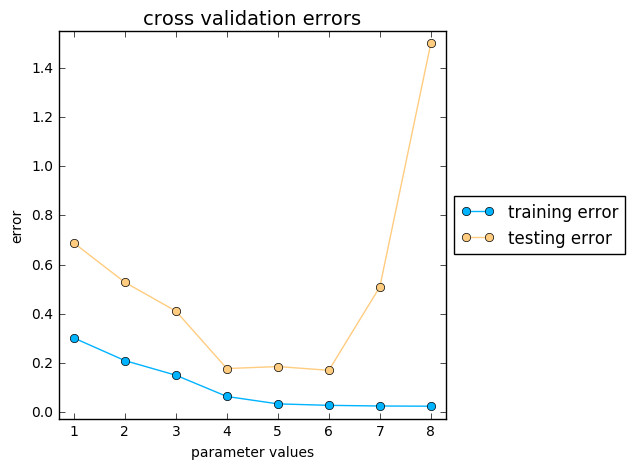

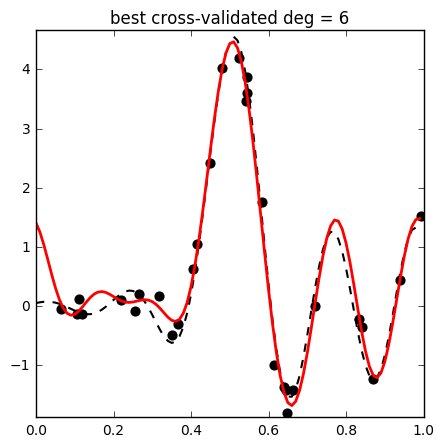

In [7]:
# run everything 
x,y = load_data('wavy_data.csv')

# split the data
k = 3    # folds to split data into
c = split_data(x,y,k)

# cross validate
fourier_degs = np.arange(1,9)
best_deg = cross_validate(x,y,c,fourier_degs,k)

# plot everything
plot_fourier(x,y,best_deg,k)
plt.show()